<a href="https://colab.research.google.com/github/BerniceJewel/Computational-Finance-Programming/blob/main/Stability_of_the_Finite_Difference_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [2]:
#Defining the exact sollution of the BSM- put option.
def black_Scholes_Put(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T)) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    putPrice = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return putPrice

In [3]:
def finite_Difference_Explicit(S0, K, T, r, sigma, n, m ):
    #Initializing the parameters
    deltaT = T / m
    deltaX = (np.log(3 * S0)- np.log(S0/3))/n

    #space  grid discretization - logarithimically spaced.
    xValues = np.linspace(np.log(S0/3), np.log(3 * S0), n+1)

    # Initializing the option value grid
    u = np.zeros((n+1, m+1))

    #Setting boundary conditions to be the Payoff at expiration.
    u[:, -1] = np.maximum(K - np.exp(xValues), 0)

    #Performing time stepping
    for j in range(m-1, -1, -1):
        for i in range(1, n):
            u[i, j] =  u[i, j+1] - r * deltaT * u[i, j+1] + \
                       (r * xValues[i] * deltaX / 2) * (u[i+1, j+1] - u[i-1, j+1]) + \
                       (sigma**2 * xValues[i]**2 * deltaT / 2) * (u[i+1, j+1] - 2*u[i, j+1] + u[i-1, j+1]) / deltaX**2

    return u

In [4]:
def tridiagonalMatrixSolver(a, b, c, d):
    #Function to solve the linear system -  Thomas algorithm (tridiagonal matrix solver)
    n = len(d)
    cDdash = np.zeros(n - 1)
    dDash = np.zeros(n)

    cDdash[0] = c[0] / b[0]
    dDash[0] = d[0] / b[0]

    for i in range(1, n - 1):
        cDdash[i] = c[i] / (b[i] - a[i] * cDdash[i - 1])
    for i in range(1, n):
        dDash[i] = (d[i] - a[i] * dDash[i - 1]) / (b[i] - a[i] * cDdash[i - 1])

    x = np.zeros(n)
    x[-1] = dDash[-1]

    for i in range(n - 2, -1, -1):
        x[i] = dDash[i] - cDdash[i] * x[i + 1]

    return x

In [5]:
def finite_Difference_Implicit(S0, K, T, r, sigma, n, m):
    #Initializing the parameters
    deltaT = T / m
    #deltaX = S0 / n
    deltaX = (np.log(3 * S0)- np.log(S0/3))/n

    #space grid discretization - logarithimically spaced.
    xValues = np.linspace(np.log(S0/3), np.log(3 * S0), n+1)

    #Initializing the option value grid
    u = np.zeros((n+1, m+1))

    #Setting boundary conditions to be the Payoff at expiration.
    u[:, -1] = np.maximum(K - np.exp(xValues), 0)

    #Implicit method coefficients
    alpha = -0.5 * (sigma**2 * xValues[1:-1]**2) * deltaT / deltaX**2
    beta = 1 + r * deltaT + sigma**2 * xValues[1:-1]**2 * deltaT
    gamma = 0.5 * (sigma**2 * xValues[1:-1]**2) * deltaT / deltaX**2

    # Performing time step using the implicit method
    for j in range(m-1, -1, -1):
        d = np.zeros(n-1)
        d[:] = -alpha * u[1:-1, j+1] + beta * u[1:-1, j+1] - gamma * u[2:, j+1]

        #Boundary conditions at S0 and 0
        d[0] -= alpha[0] * u[0, j+1]
        d[-1] -= gamma[-1] * u[n, j+1]

        u[1:-1, j] = tridiagonalMatrixSolver(-alpha, beta, -gamma, d)

    return u

In [6]:
def finite_Difference_CrankNicolson(S0, K, T, r, sigma, n, m):
    #Initializing the parameters
    deltaT = T / m
    #deltaX = S0 / n
    deltaX = (np.log(3 * S0)- np.log(S0/3))/n

    #space grid discretization - logarithimically spaced.
    xValues = np.linspace(np.log(S0/3), np.log(3 * S0), n+1)

    #Initializing the option value grid
    u = np.zeros((n+1, m+1))

    #Setting the boundary conditions to be the Payoff at expiration.
    u[:, -1] = np.maximum(K - np.exp(xValues), 0)

    # Crank-Nicolson method coefficients
    alpha = -0.25 * (sigma**2 * xValues[1:-1]**2) * deltaT / deltaX**2
    beta = 1 + 0.5 * r * deltaT + 0.5 * sigma**2 * xValues[1:-1]**2 * deltaT
    gamma = 0.25 * (sigma**2 * xValues[1:-1]**2) * deltaT / deltaX**2

    # Performing time steps using the Crank-Nicolson method
    for j in range(m-1, -1, -1):
        d = np.zeros(n-1)
        d[:] = -alpha * u[1:-1, j+1] + beta * u[1:-1, j+1] - gamma * u[2:, j+1]

        # Boundary conditions at S0 and 0
        d[0] -= alpha[0] * (u[0, j+1] + u[0, j])
        d[-1] -= gamma[-1] * (u[n, j+1] + u[n, j])

        u[1:-1, j] = tridiagonalMatrixSolver(-alpha, beta, -gamma, d)

    return u



In [7]:
def option_Price(S0, K, T, r, sigma, n, m,methodFunc):
    option_Values = methodFunc(S0, K, T, r, sigma, n, m)
    option_Price = option_Values[int(n/2), 0]
    return option_Price

#Defining an error Function.
def error(actual,calculated):
    err = np.abs(np.array(calculated) - np.array(actual))
    return err

In [8]:
S0 = 5  #Underlying price range
K = 10  #European put underlying strike Price
T = 0.5    # time to maturity
r = 0.05  #risk-free rate
sigma = 0.2  # volatility
S = np.arange(5, 16, 1)

n = 100   # number of space steps
m = 30  #time-steps

#Calculating the Black-Scholes prices
bs_Put_Prices = [black_Scholes_Put(s, K, r, sigma, T) for s in S]

#Calculating finite difference method prices
explicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Explicit) for s in S]
implicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Implicit) for s in S]
cn_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_CrankNicolson) for s in S]

#newError = error(bsPutPrices,explicitPrices2)
explicit_Errors = error(bs_Put_Prices,explicit_Prices)
implicit_Errors = error(bs_Put_Prices,implicit_Prices)
cn_Errors = error(bs_Put_Prices,cn_Prices)

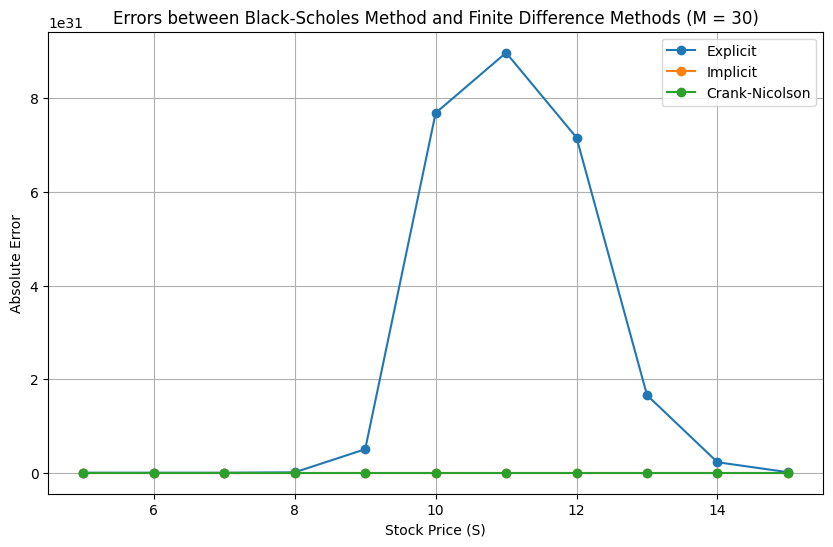

In [9]:
#1.) Question 1
# Plotting the errors when M = 30
plt.figure(figsize=(10, 6))
plt.plot(S, explicit_Errors, label="Explicit", marker="o")
plt.plot(S, implicit_Errors, label="Implicit", marker="o")
plt.plot(S, cn_Errors, label="Crank-Nicolson", marker="o")
#plt.plot(S, newError, label="ExplicitTwo", marker="o")
plt.xlabel("Stock Price (S)")
plt.ylabel("Absolute Error")
plt.title("Errors between Black-Scholes Method and Finite Difference Methods (M = 30)")
plt.legend()
plt.grid(True)
plt.show()

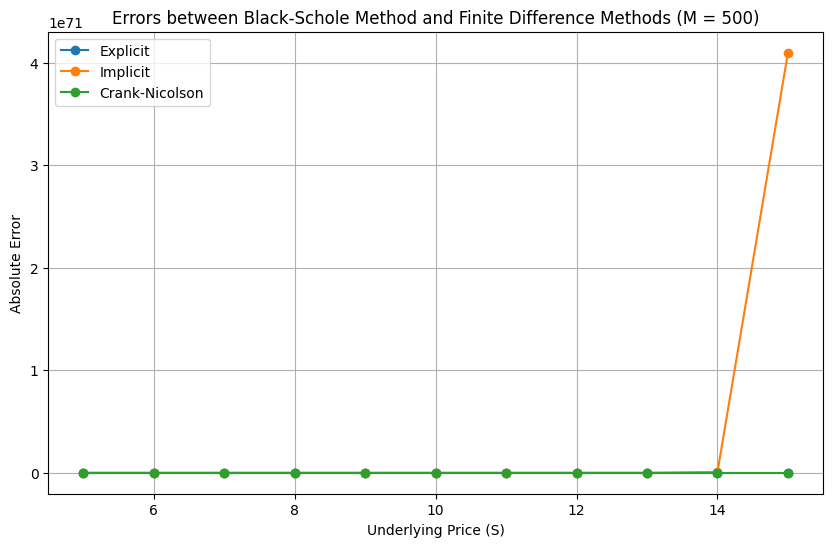

In [10]:
# Plotting the errors when M = 500
m = 500
#Finite difference res.
explicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Explicit) for s in S]
implicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Implicit) for s in S]
cn_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_CrankNicolson) for s in S]
#Errors
explicit_Errors = error(bs_Put_Prices,explicit_Prices)
implicitErrors = error(bs_Put_Prices,implicit_Prices)
cnErrors = error(bs_Put_Prices,cn_Prices)
#Plots.
plt.figure(figsize=(10, 6))
plt.plot(S, explicit_Prices, label='Explicit',marker="o")
plt.plot(S, implicit_Prices, label='Implicit',marker="o")
plt.plot(S, cn_Prices, label='Crank-Nicolson',marker="o")
plt.xlabel('Underlying Price (S)')
plt.ylabel('Absolute Error')
plt.title('Errors between Black-Schole Method and Finite Difference Methods (M = 500)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#Question 2.
K = 10
T = 0.5
r = 0.05
sigma = 0.4
S = np.arange(5, 16, 1)
n = 200
m = 30

# Calculating Black-Scholes prices
bs_Put_Prices = [black_Scholes_Put(s, K, r, sigma, T) for s in S]

#Calculating finite difference method prices
explicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Explicit) for s in S]
implicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Implicit) for s in S]
cn_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_CrankNicolson) for s in S]

explicit_Errors = error(bs_Put_Prices,explicit_Prices)
implicit_Errors = error(bs_Put_Prices,implicit_Prices)
cn_Errors = error(bs_Put_Prices,cn_Prices)

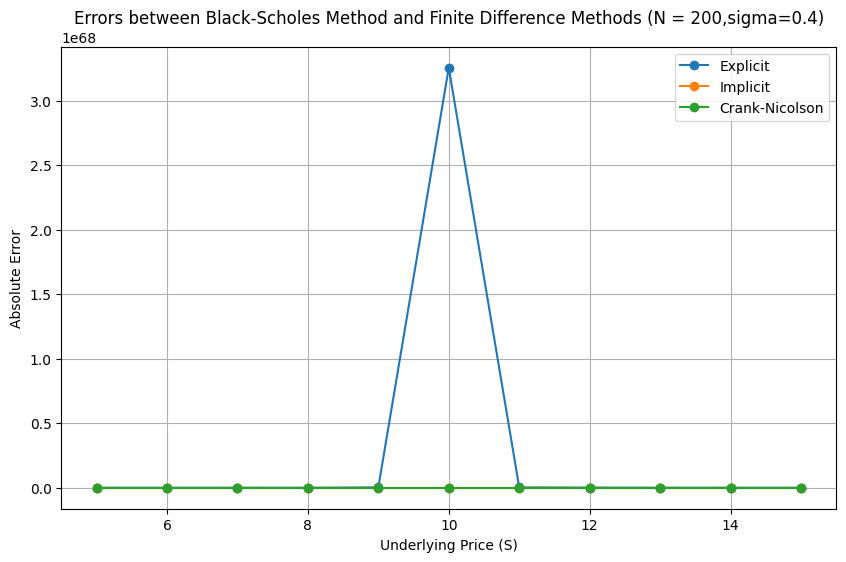

In [12]:
# Plotting errors
plt.figure(figsize=(10, 6))
plt.plot(S, explicit_Errors, label='Explicit',marker="o")
plt.plot(S, implicit_Errors, label='Implicit',marker="o")
plt.plot(S, cn_Errors, label='Crank-Nicolson',marker="o")
plt.xlabel('Underlying Price (S)')
plt.ylabel('Absolute Error')
plt.title('Errors between Black-Scholes Method and Finite Difference Methods (N = 200,sigma=0.4)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:

S0 = 100
K = 10
T = 0.5
r = 0.05
sigma = 0.4
S = np.arange(5, 16, 1)
n = 700
m = 30

# Calculating Black-Scholes prices
bs_Put_Prices = [black_Scholes_Put(s, K, r, sigma, T) for s in S]

#Calculating finite difference method prices
explicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Explicit) for s in S]
implicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Implicit) for s in S]
cn_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_CrankNicolson) for s in S]

explicit_Errors = error(bs_Put_Prices,explicit_Prices)
implicit_Errors = error(bs_Put_Prices,implicit_Prices)
cn_Errors = error(bs_Put_Prices,cn_Prices)

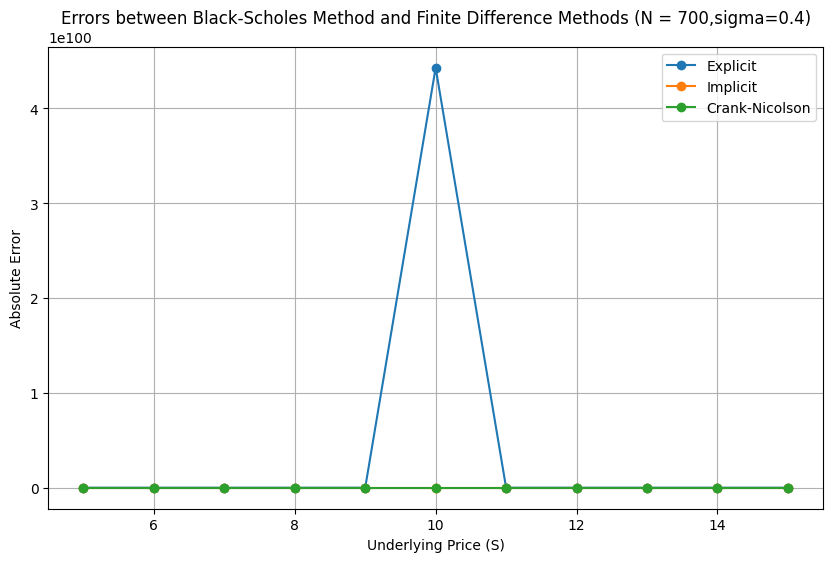

In [14]:
# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(S, explicit_Errors, label='Explicit',marker="o")
plt.plot(S, implicit_Errors, label='Implicit',marker="o")
plt.plot(S, cn_Errors, label='Crank-Nicolson',marker="o")
plt.xlabel('Underlying Price (S)')
plt.ylabel('Absolute Error')
plt.title('Errors between Black-Scholes Method and Finite Difference Methods (N = 700,sigma=0.4)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#Question 3.
K = 10
T = 0.5
r = 0.05
sigma = 0.5
S = np.arange(5, 16, 1)
n = 700
m = 30

# Calculating the Black-Scholes prices
bs_Put_Prices = [black_Scholes_Put(s, K, r, sigma, T) for s in S]

#Calculating finite difference method prices
explicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Explicit) for s in S]
implicit_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_Implicit) for s in S]
cn_Prices =  [option_Price(s, K, T,r,sigma,n,m,finite_Difference_CrankNicolson) for s in S]

explicit_Errors = error(bs_Put_Prices,explicit_Prices)
implicit_Errors = error(bs_Put_Prices,implicit_Prices)
cn_Errors = error(bs_Put_Prices,cn_Prices)

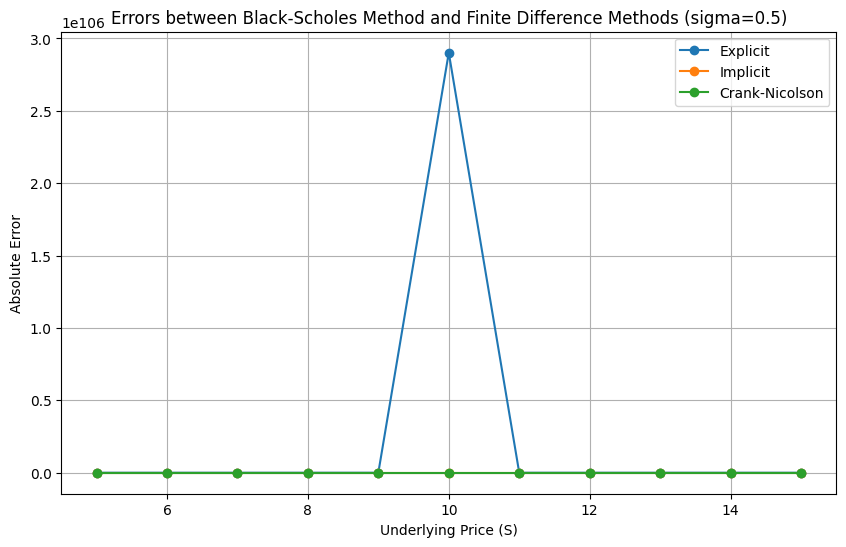

In [16]:
# Plotting errors
plt.figure(figsize=(10, 6))
plt.plot(S, explicit_Errors, label='Explicit',marker="o")
plt.plot(S, implicit_Errors, label='Implicit',marker="o")
plt.plot(S, cnErrors, label='Crank-Nicolson',marker="o")
plt.xlabel('Underlying Price (S)')
plt.ylabel('Absolute Error')
plt.title('Errors between Black-Scholes Method and Finite Difference Methods (sigma=0.5)')
plt.legend()
plt.grid(True)
plt.show()